<a href="https://colab.research.google.com/github/kiyong21c/Must_Have_pytorch_DL/blob/main/20220831_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 손글씨 이미지를 입력받아 숫자 에측
 - 알고리즘 : MLP
 - 문제유형 : 다중분류
 - 평가지표 : CE오차

In [ ]:
import matplotlib.pyplot as plt

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 학습용 데이터 평가용 데이터 분리
training_data = MNIST(root='./', train=True, download=True, transform=ToTensor())
test_data = MNIST(root='./', train=True, download=True, transform=ToTensor())

In [4]:
print(len(training_data), len(test_data))

60000 60000


In [12]:
# training_data의 클래스 확인
training_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [21]:
# training_data의 레이블 확인
training_data.train_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [13]:
# training_data의 데이터 차원 확인
training_data.data.shape

torch.Size([60000, 28, 28])

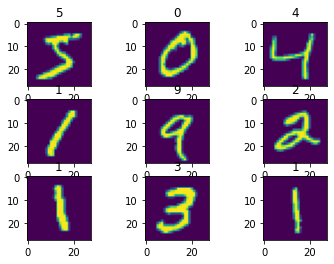

In [24]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(training_data.data[i])
    plt.title(training_data.train_labels[i].item()); # item() : tensor의 값만 가져오기

### 데이터 불러오기 
 - Dataloader() 메서드 : 학습/평가에 사용할 배치를 자동으로 반환
 - 배치 크기, 셔플여부, 사용될 CPU개수 등 설정

In [26]:
from torch.utils.data.dataloader import DataLoader


train_loader = DataLoader(training_data, batch_size=32, shuffle=True) # 학습에 사용되는 데이터는 섞어주자
# training_data의 60000개의 숫자가 0부터 순차적이라면 학습에 문제가 될 것  → 섞어준다


# 평가용 데이터는 학습에 사용되는것이 아니므로 섞을 필요 없음
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [27]:
train_loader # 데이터로더는 제너레이터

In [54]:
len(train_loader) # 1875 : 60000개의 이미지를 배치크기(32)로 나누었을 때 1875

1875

In [ ]:
dir(train_loader) # __iter__ : iter(데이터로더)

In [ ]:
dir(iter(train_loader)) # __next__, next : 두가지 방식으로 메서드 사용 가능

In [45]:
# 1) __next__ 메서드 사용
data, label = next(iter(train_loader))
print(data.shape, label.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [44]:
# 2) next 메서드 사용
data, label = iter(train_loader).next()
print(data.shape, label.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [48]:
import numpy as np
def imshow(img):
    torch_img = img/2 + 0.5 # unnormalize
    np_img = torch_img.numpy() # imshow(np_img)
    plt.imshow(np.transpose(np_img, (1,2,0)))

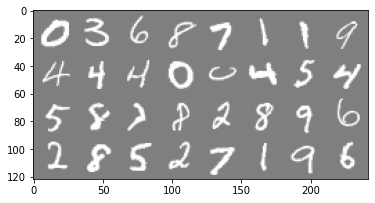

In [53]:
import torchvision
# torchvision.utils.make_grid(data).shape # torch.Size([3, 122, 242]) : RGB, Height, Width
imshow(torchvision.utils.make_grid(data))

### 모델 정의 및 학습하기
 - 이미지 학습에 드는 계산량이 많으므로 GPU 이용

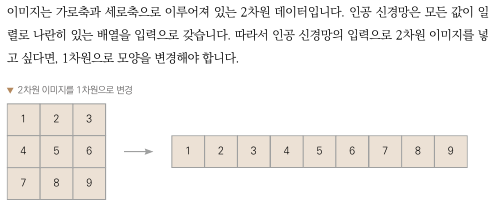

In [55]:
import torch
import torch.nn as nn

from torch.optim.adam import Adam

# 학습에 사용할 프로세서 지정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(nn.Linear(784, 64),   # MNIST의 이미지는 모두 28X28(784픽셀)
                      nn.ReLU(),    
                      nn.Linear(64, 64),
                      nn.ReLU(),  
                      nn.Linear(64, 10))
model.to(device) # 모델의 파라미터를 GPU로 보냄

lr = 1e-3
optim = Adam(model.parameters(), lr=lr)

# 전체데이터를 20번 반복학습
for epoch in range(20):
    for data, labels in train_loader: # len(train_loader) : 1875, 즉 1875회 순회
        
        # data, labels를 GPU로 보냄
        labels = labels.to(device)
        data = data.reshape(-1, 784).to(device) # data가 numpy/tensor배열 일때 reshape 방법
        # data = torch.reshape(data, (-1, 784)).to(device) # data가 tensor 배열 일때 reshape 방법
        
        optim.zero_grad()   # 오차에 대한 각 가중치의 미분값 초기화
        # 입력 데이터 모양을 MLP모델의 입력에 맞게(1차원 벡터) 변환
        preds = model(data)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(preds, labels)
        loss.backward() # 오차에 대한 각 가중치의 미분값 계산 및 저장
        optim.step()    # 가중치 업데이트
    
    print(f'epoch{epoch+1} loss:{loss.item()}')

torch.save(model.state_dict(), "MNIST.pth") # 파이토치 모델의 파라미터(가중치)를 딕셔너리형태로 저장

epoch1 loss:0.05460299178957939
epoch2 loss:0.05946794152259827
epoch3 loss:0.1570914089679718
epoch4 loss:0.019854379817843437
epoch5 loss:0.061649441719055176
epoch6 loss:0.01879560761153698
epoch7 loss:0.039745740592479706
epoch8 loss:0.003945529460906982
epoch9 loss:0.10063977539539337
epoch10 loss:0.00634101964533329
epoch11 loss:0.09331946820020676
epoch12 loss:0.01891273260116577
epoch13 loss:0.0113759133964777
epoch14 loss:0.016848336905241013
epoch15 loss:0.005009220913052559
epoch16 loss:0.0014346587704494596
epoch17 loss:0.00038900115760043263
epoch18 loss:0.0008175951661542058
epoch19 loss:0.08810676634311676
epoch20 loss:2.1697453121305443e-05


### 모델 성능 평가하기


In [63]:
model.load_state_dict(torch.load("MNIST.pth", map_location=device)) # map_location : 불러올 위치

num_corr = 0 # 분류에 성공한 전체 개수 초기화

with torch.no_grad():   # 기울기를 계산하지 않음(학습할때만 손실에 대한 가중치 미분값 계산이 필요)
    for data, label in test_loader:
        data = data.reshape(-1, 784).to(device)
        label = label.to(device)

        preds = model(data)

print(num_corr)


RuntimeError: ignored

In [60]:
a = torch.tensor([0,0,0,0,0,1])
b = torch.tensor([0,0,0,1,0,0])

a.eq(b)

tensor([ True,  True,  True, False,  True, False])

In [61]:
a.eq(b).sum().item()

4